# Собираем статистику

In [1]:
# -*- coding: utf-8 -*-
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from lxml import objectify
from pandas import DataFrame
from datetime import datetime, date, time
from dateutil.parser import parse
import pandas as pd
import numpy as np
import sklearn as sk
import time
import sys
from sklearn import metrics
import re

## Пакет графиков в новом окне

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

## Источник данных

In [3]:
%%time
#В папке TMdata лежит наш XML файл который будем читать. В итоге в Root будут распарсенные XML элементы
path = 'TMdata/xmlWikiOrderByDate.xml'
parsed = objectify.parse(open(path))
root = parsed.getroot()

Wall time: 609 ms


In [4]:
stop_words = ['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', \
             'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', \
             'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', \
             'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', \
             'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', \
             'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', \
             'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', \
             'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', \
             'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', \
             'много', 'разве', 'три', 'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда', 'лучше', 'чуть', \
             'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между']

## DataFrame 

In [ ]:
%%time
#Последняя рабочая долгая версия 
dftime = pd.DataFrame (columns=('id', 'data', 'category', 'title', 'content'))
skip_fieldst2 = ['text', 'userid', 'title', 'data', 'autor', 'id', 'content']
for eltime in root.page:
    for childt in eltime.getchildren():
        if childt.tag in skip_fieldst2:
            continue
        dout=re.sub(r'(\d+)-(\d+)-(\d+)', r'01-\2-\3', eltime.data.pyval)
        dd=datetime.strptime(dout, '%d-%m-%Y')
        #dd=dd.resample("Y")
        rowt = dict(zip(['id', 'data', 'category', 'title', 'content'], 
                        [eltime.id.pyval, dd, childt.pyval, eltime.title.pyval, eltime.content.pyval]))
        row_st = pd.Series(rowt)
        row_st.name=eltime.id.pyval
        dftime = dftime.append(row_st)

In [ ]:
#Сохраняем датафрейм, чтобы постоянно не считать
dftime.to_pickle('TMdata/dftime.pkl')

In [4]:
#Загрузка из датафрейма
dftime = pd.read_pickle('TMdata/dftime.pkl')

In [5]:
dftime.head()

,id,data,category,title,content
7376,7376,2005-02-01,Барнаул,Умер Владимир Мефодьевич Башунов,\n Сегодня утром из Барнаула пришло печал...
7376,7376,2005-02-01,Алтайский край,Умер Владимир Мефодьевич Башунов,\n Сегодня утром из Барнаула пришло печал...
7376,7376,2005-02-01,Некрологи,Умер Владимир Мефодьевич Башунов,\n Сегодня утром из Барнаула пришло печал...
7376,7376,2005-02-01,Писатели,Умер Владимир Мефодьевич Башунов,\n Сегодня утром из Барнаула пришло печал...
7376,7376,2005-02-01,Россия,Умер Владимир Мефодьевич Башунов,\n Сегодня утром из Барнаула пришло печал...


## Подсчет статистики количество слов в корпусе по годам

In [34]:
list_dat_2=['2005-1-1', '2006-1-1', '2007-1-1', '2008-1-1', '2009-1-1', '2010-1-1', '2011-1-1', '2012-1-1', '2013-1-1', '2014-1-1', '2015-1-1']

In [ ]:
list_dat=['2005-1-1', '2006-1-1', '2007-1-1', '2008-1-1', '2009-1-1', '2010-1-1', '2011-1-1', '2012-1-1', '2013-1-1', '2014-1-1']

In [8]:
df_count_word = pd.DataFrame(columns=('2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
                                      '2013-01-01', '2014-01-01', '2015-1-1'))

In [19]:
df_count_word_all = pd.DataFrame(columns=('Date', 'Count_word'))

In [20]:
%%time
n=0
for d in list_dat:
    n+=1
    if len(list_dat)<=n:
        break
    mask = (dftime['data'] >= list_dat[n-1]) & (dftime['data'] < list_dat[n])
    df_1 = dftime.loc[mask]
    data_content=df_1['content'].tolist()
    if len(data_content)>0:
        vectorizerContent_all= CountVectorizer (min_df=1, stop_words=stop_words)
        pwd_all = vectorizerContent_all.fit_transform(data_content)
        select_feature_names_Cont_all=np.asarray(vectorizerContent_all.get_feature_names())
        rowt = dict(zip(['Count_word'], [len(select_feature_names_Cont_all)]))
        row_st = pd.Series(rowt)
        row_st.name=list_dat[n-1]
        df_count_word_all = df_count_word_all.append(row_st)
        if len(data_content)==1:
            print len(select_feature_names_Cont_all)
    else:
        zer=0
        rowt = dict(zip(['Count_word'], [zer]))
        row_st = pd.Series(rowt)
        row_st.name=list_dat[n-1]

Wall time: 29.1 s


In [21]:
df_count_word_all.drop('Date', axis=1, inplace=True)

In [22]:
df_count_word_all.head()

,Count_word
2005-1-1,6856
2006-1-1,27515
2007-1-1,15781
2008-1-1,17533
2009-1-1,21314


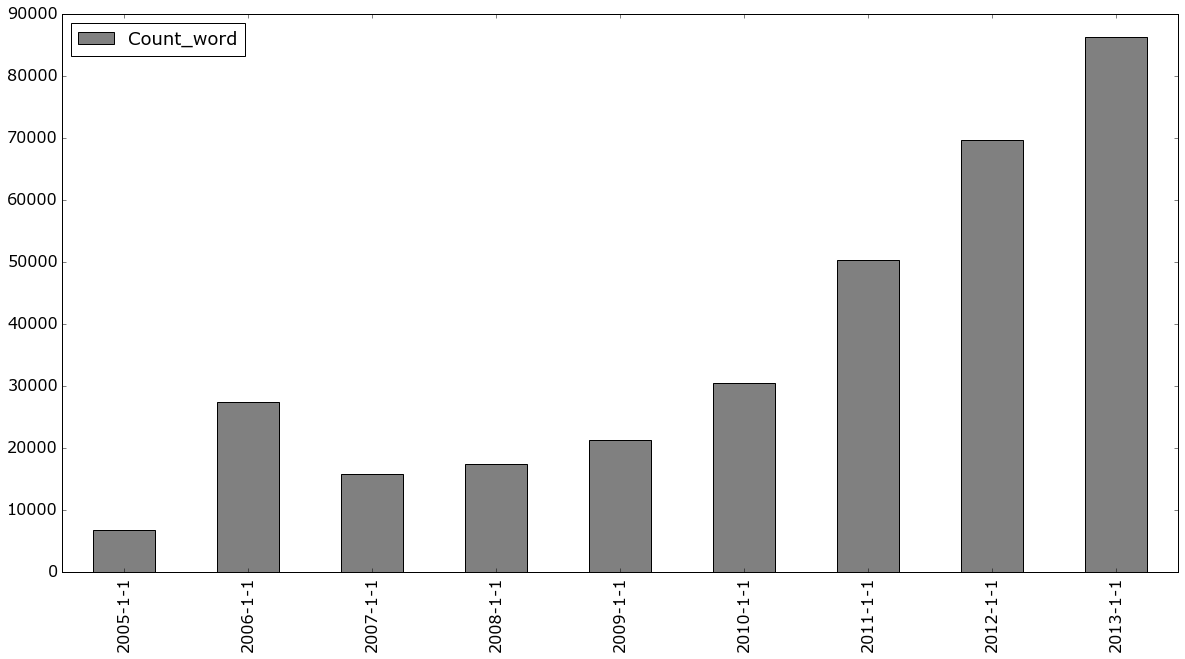

In [27]:
df_count_word_all.plot.bar(color='gray')
rcParams['font.family'] = 'Verdana'
rcParams['font.size'] = 16
rcParams['legend.fontsize'] = 18
rcParams['figure.figsize'] = 20, 10
rcParams['figure.facecolor'] = 'white'
rcParams['figure.edgecolor'] = 'black'
rcParams['figure.edgecolor'] = 'gray'
rcParams['legend.frameon'] = True
plt.show()

## Подсчет количества документов по категориям

In [28]:
df_count_doc = pd.DataFrame(columns=('2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
                                      '2013-01-01', '2014-01-01', '2015-1-1'))

In [29]:
dftime['category'].count()

79694

### Выбираем категории где больше 50 документов

In [31]:
dftimeR=dftime.groupby(['category']).filter(lambda x: x['category'].value_counts() > 50)
dftimeR.head()


,id,data,category,title,content
7376,7376,2005-02-01,Некрологи,Умер Владимир Мефодьевич Башунов,\n Сегодня утром из Барнаула пришло печал...
7376,7376,2005-02-01,Россия,Умер Владимир Мефодьевич Башунов,\n Сегодня утром из Барнаула пришло печал...
1349,1349,2005-11-01,Россия,Россия удивлена заявлениями Премьер-министра У...,\n Украина\n В Москве обратили внима...
1349,1349,2005-11-01,Украина,Россия удивлена заявлениями Премьер-министра У...,\n Украина\n В Москве обратили внима...
1349,1349,2005-11-01,Политика,Россия удивлена заявлениями Премьер-министра У...,\n Украина\n В Москве обратили внима...


In [32]:
%%time
dfTimeUniqCatR=pd.unique(dftimeR.category.ravel())
print len(dfTimeUniqCatR)

230
Wall time: 5 ms


In [35]:
for cat in dfTimeUniqCatR:
    n=0
    #print cat
    count_doc=[]
    for d in list_dat_2:
        n+=1
        if len(list_dat_2) <= n:
            break
        mask = (dftime['data'] >= list_dat_2[0]) & (dftime['data'] < list_dat_2[n]) & (dftime['category']==cat)
        df_1=dftime.loc[mask]
        count_doc.append(df_1['content'].count())
    rowt = dict(zip(['2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01'], 
                  [count_doc[0], count_doc[1], count_doc[2], count_doc[3], count_doc[4], count_doc[5], count_doc[6], count_doc[7], count_doc[8], count_doc[9]]))
    row_st = pd.Series(rowt)
    row_st.name=cat
    df_count_doc = df_count_doc.append(row_st)
df_count_doc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, Некрологи to Вооружённый конфликт в Украине (2014)
Data columns (total 11 columns):
2005-01-01    230 non-null float64
2006-01-01    230 non-null float64
2007-01-01    230 non-null float64
2008-01-01    230 non-null float64
2009-01-01    230 non-null float64
2010-01-01    230 non-null float64
2011-01-01    230 non-null float64
2012-01-01    230 non-null float64
2013-01-01    230 non-null float64
2014-01-01    230 non-null float64
2015-1-1      0 non-null float64
dtypes: float64(11)
memory usage: 21.6+ KB


In [43]:
df_count_doc.drop('2015-1-1', axis=1, inplace=True)

In [44]:
df_count_doc.head()

,2005-01-01,2006-01-01,2007-01-01,2008-01-01,2009-01-01,2010-01-01,2011-01-01,2012-01-01,2013-01-01,2014-01-01
Некрологи,3,12,15,21,27,35,54,84,125,140
Россия,14,105,161,199,238,291,360,677,1356,1904
Украина,3,12,14,18,24,29,33,73,168,539
Политика,19,102,148,176,202,253,379,672,1364,1912
Астрономия,3,15,16,20,23,27,30,38,54,65


In [45]:
df_count_doc_T=df_count_doc.transpose()

In [ ]:
df_count_doc_T_2=df_count_doc_T[[u'Некрологи', u'Россия', u'Украина', u'Политика', u'Астрономия', u'Праздники']]
df_count_doc_T_2.head()

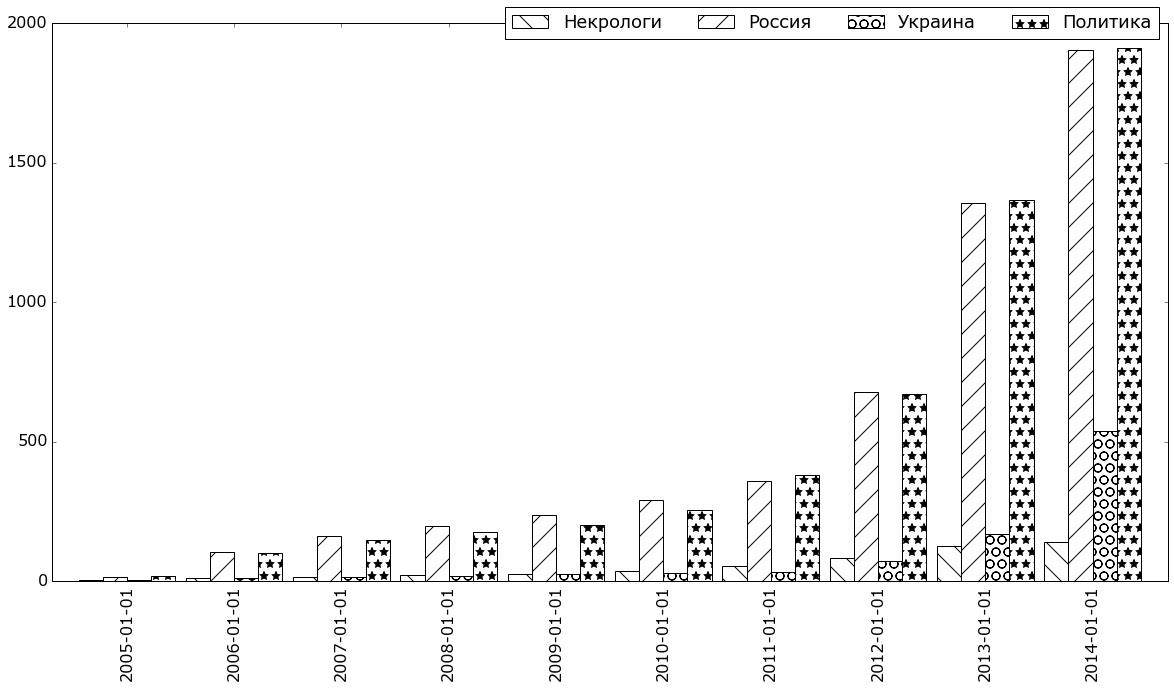

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111)
df_count_doc_T_2=df_count_doc_T[[u'Некрологи', u'Россия', u'Украина', u'Политика']]
df_count_doc_T_2.plot(ax=ax, kind='bar', legend=False, color='white', width=0.9)
bars = ax.patches
hatches = ''.join(h*len(df_count_doc_T_2) for h in '\/O*')
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
ax.legend(loc='center right', bbox_to_anchor=(1, 1), ncol=4)
plt.show()

### Подсчет слов по категориям

In [ ]:
%%time
for cat in dfTimeUniqCatR:
    n=0
    print cat
    count_dat=[]
    for d in list_dat:
        n+=1
        if len(list_dat) <= n:
            break
        
        mask = (dftime['data'] >= list_dat[0]) & (dftime['data'] < list_dat[n]) & (dftime['category']==cat)
        
        df_1=dftime.loc[mask]
        data_content=df_1['content'].tolist()
        if len(data_content) > 0:
            #print len(data_content)
            vectorizerContent1=CountVectorizer (min_df=1, stop_words=stop_words)
            pwd1 = vectorizerContent1.fit_transform(data_content)
            selected_feature_names_Cont1 = np.asarray(vectorizerContent1.get_feature_names())
            count_dat.append(len(selected_feature_names_Cont1))
            if len(data_content) ==1 :
                print len(selected_feature_names_Cont1)
        else:
            count_dat.append(0)
            
        
    
    rowt = dict(zip(['2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01'], 
                  [count_dat[0], count_dat[1], count_dat[2], count_dat[3], count_dat[4], count_dat[5], count_dat[6], count_dat[7], count_dat[8], count_dat[9]]))
    row_st = pd.Series(rowt)
    row_st.name=cat
    df_count_word = df_count_word.append(row_st)


In [ ]:
#Сохраняем датафрейм, чтобы постоянно не считать
df_count_word.to_pickle('TMdata/df_count_word.pkl')

In [95]:
#Загрузка из датафрейма
df_count_word = pd.read_pickle('TMdata/df_count_word.pkl')

In [96]:
df_count_word.head()

,2005-01-01,2006-01-01,2007-01-01,2008-01-01,2009-01-01,2010-01-01,2011-01-01,2012-01-01,2013-01-01,2014-01-01
Некрологи,325,1019,1568,2133,2681,3244,5425,7424,11678,13188
Россия,1135,9945,12922,15058,16974,19452,23095,46560,76708,92411
Украина,317,1069,1203,1834,3261,3677,4086,11199,19760,40898
Политика,1426,9001,11548,13596,15003,17390,23064,42618,68115,82416
Астрономия,182,1555,1625,1868,2154,2599,3149,3752,4795,6275


In [97]:
df_count_word_T=df_count_word.transpose()

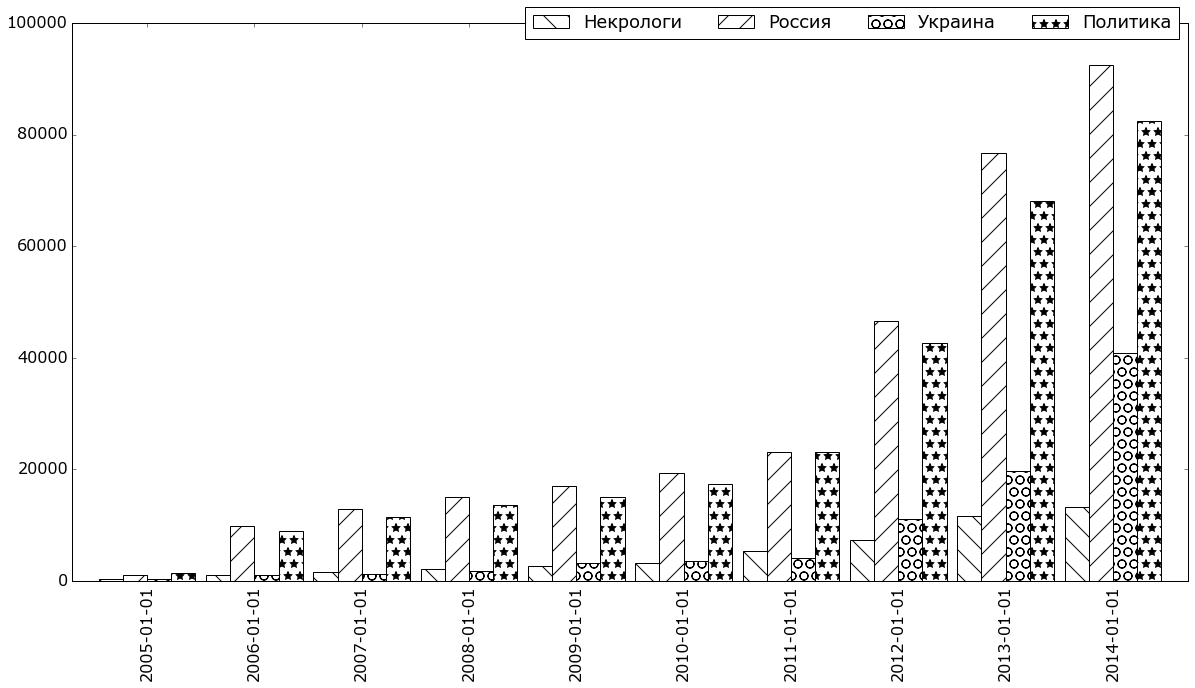

In [99]:
fig = plt.figure()
ax = fig.add_subplot(111)
df_count_word_T_2=df_count_word_T[[u'Некрологи', u'Россия', u'Украина', u'Политика']]
df_count_word_T_2.plot(ax=ax, kind='bar', legend=False, color='white', width=0.9)
bars = ax.patches
hatches = ''.join(h*len(df_count_doc_T_2) for h in '\/O*')
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
ax.legend(loc='center right', bbox_to_anchor=(1, 1), ncol=4)
plt.show()